In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vector Quantized Variational Autoencoders for 3D reconstruction of images

This tutorial illustrates how to use MONAI for training a Vector Quantized Variational Autoencoder (VQVAE)[1] on 3D images.

Here, we will train our VQVAE model to be able to reconstruct the input images.  We will work with the Decathlon Dataset available on [MONAI](https://docs.monai.io/en/stable/apps.html#monai.apps.DecathlonDataset). In order to train faster, we will select just one of the available tasks ("Task01_BrainTumour").

The VQVAE can also be used as a generative model if an autoregressor model (e.g., PixelCNN, Decoder Transformer) is trained on the discrete latent representations of the VQVAE bottleneck. This falls outside of the scope of this tutorial.

[1] - Oord et al. "Neural Discrete Representation Learning" https://arxiv.org/abs/1711.00937


### Set up environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

### Setup imports

In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch.nn import L1Loss
from tqdm import tqdm

from generative.networks.nets import VQVAE

print_config()

MONAI version: 1.1.dev2248
Numpy version: 1.23.3
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 3400bd91422ccba9ccc3aa2ffe7fecd4eb5596bf
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai

In [2]:
# for reproducibility purposes set a seed
set_determinism(42)

### Setup a data directory

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not
specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpc398pj0s


### Setup used transforms and download dataset

In [4]:
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.AddChanneld(keys=["image"]),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.AddChanneld(keys=["image"]),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

/media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [5]:
train_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=train_transform, section="training", download=True
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8)

val_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=val_transform, section="validation", download=True
)

val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=8, persistent_workers=True)

Task01_BrainTumour.tar: 7.09GB [07:59, 15.9MB/s]                                                                                                                                                                                

2022-11-30 00:27:21,262 - INFO - Downloaded: /tmp/tmpc398pj0s/Task01_BrainTumour.tar


2022-11-30 00:27:29,463 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2022-11-30 00:27:29,464 - INFO - Writing into directory: /tmp/tmpc398pj0s.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [03:31<00:00,  1.84it/s]


2022-11-30 00:31:12,636 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2022-11-30 00:31:12,636 - INFO - File exists: /tmp/tmpc398pj0s/Task01_BrainTumour.tar, skipped downloading.
2022-11-30 00:31:12,637 - INFO - Non-empty folder exists in /tmp/tmpc398pj0s/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:52<00:00,  1.82it/s]


### Visualize the training images

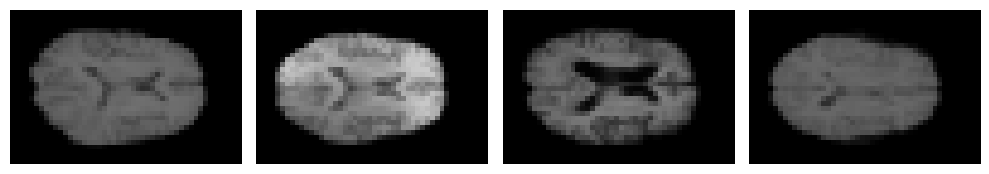

In [6]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, optimizer and losses

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = VQVAE(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=(256, 256),
    num_res_channels=256,
    num_res_layers=2,
    downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
    upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
    num_embeddings=256,
    embedding_dim=32,
)
model.to(device)

Using cuda


VQVAE(
  (encoder): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (A): ReLU()
      )
    )
    (1): VQVAEResidualUnit(
      (conv1): Convolution(
        (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
          (D): Dropout(p=0.1, inplace=False)
          (A): ReLU()
        )
      )
      (conv2): Convolution(
        (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
    )
    (2): VQVAEResidualUnit(
      (conv1): Convolution(
        (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
          (D): Dropout(p=0.1, inplace=False)
          (A): ReLU()
        )
      )
      (conv2): Convolution(
        (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
    )
    (3): Convolution(
     

In [9]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
l1_loss = L1Loss()

### Model training
Here, we are training our model for 100 epochs (training time: ~60 minutes).

In [10]:
n_epochs = 100
val_interval = 10
epoch_recon_loss_list = []
epoch_quant_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        # model outputs reconstruction and the quantization error
        reconstruction, quantization_loss = model(images=images)

        recons_loss = l1_loss(reconstruction.float(), images.float())

        loss = recons_loss + quantization_loss

        loss.backward()
        optimizer.step()

        epoch_loss += recons_loss.item()

        progress_bar.set_postfix(
            {"recons_loss": epoch_loss / (step + 1), "quantization_loss": quantization_loss.item() / (step + 1)}
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_quant_loss_list.append(quantization_loss.item() / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                reconstruction, quantization_loss = model(images=images)

                # get the first sample from the first validation batch for
                # visualizing how the training evolves
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 99: 100%|███████████████| 25/25 [00:37<00:00,  1.51s/it, recons_loss=0.00768, quantization_loss=1.91e-6]


train completed, total time: 3827.494425058365.


### Learning curves

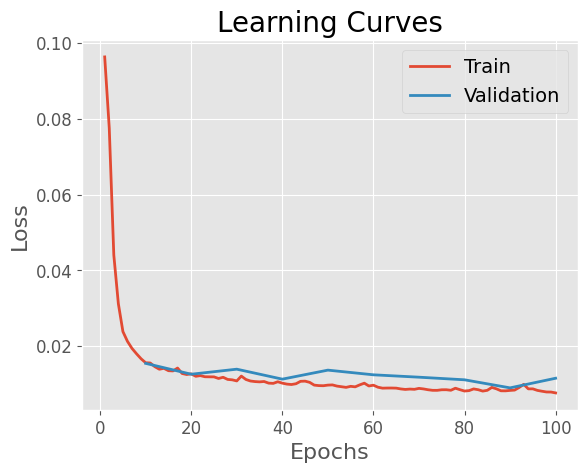

In [11]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_recon_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_recon_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

###  Plotting  evolution of reconstructed images

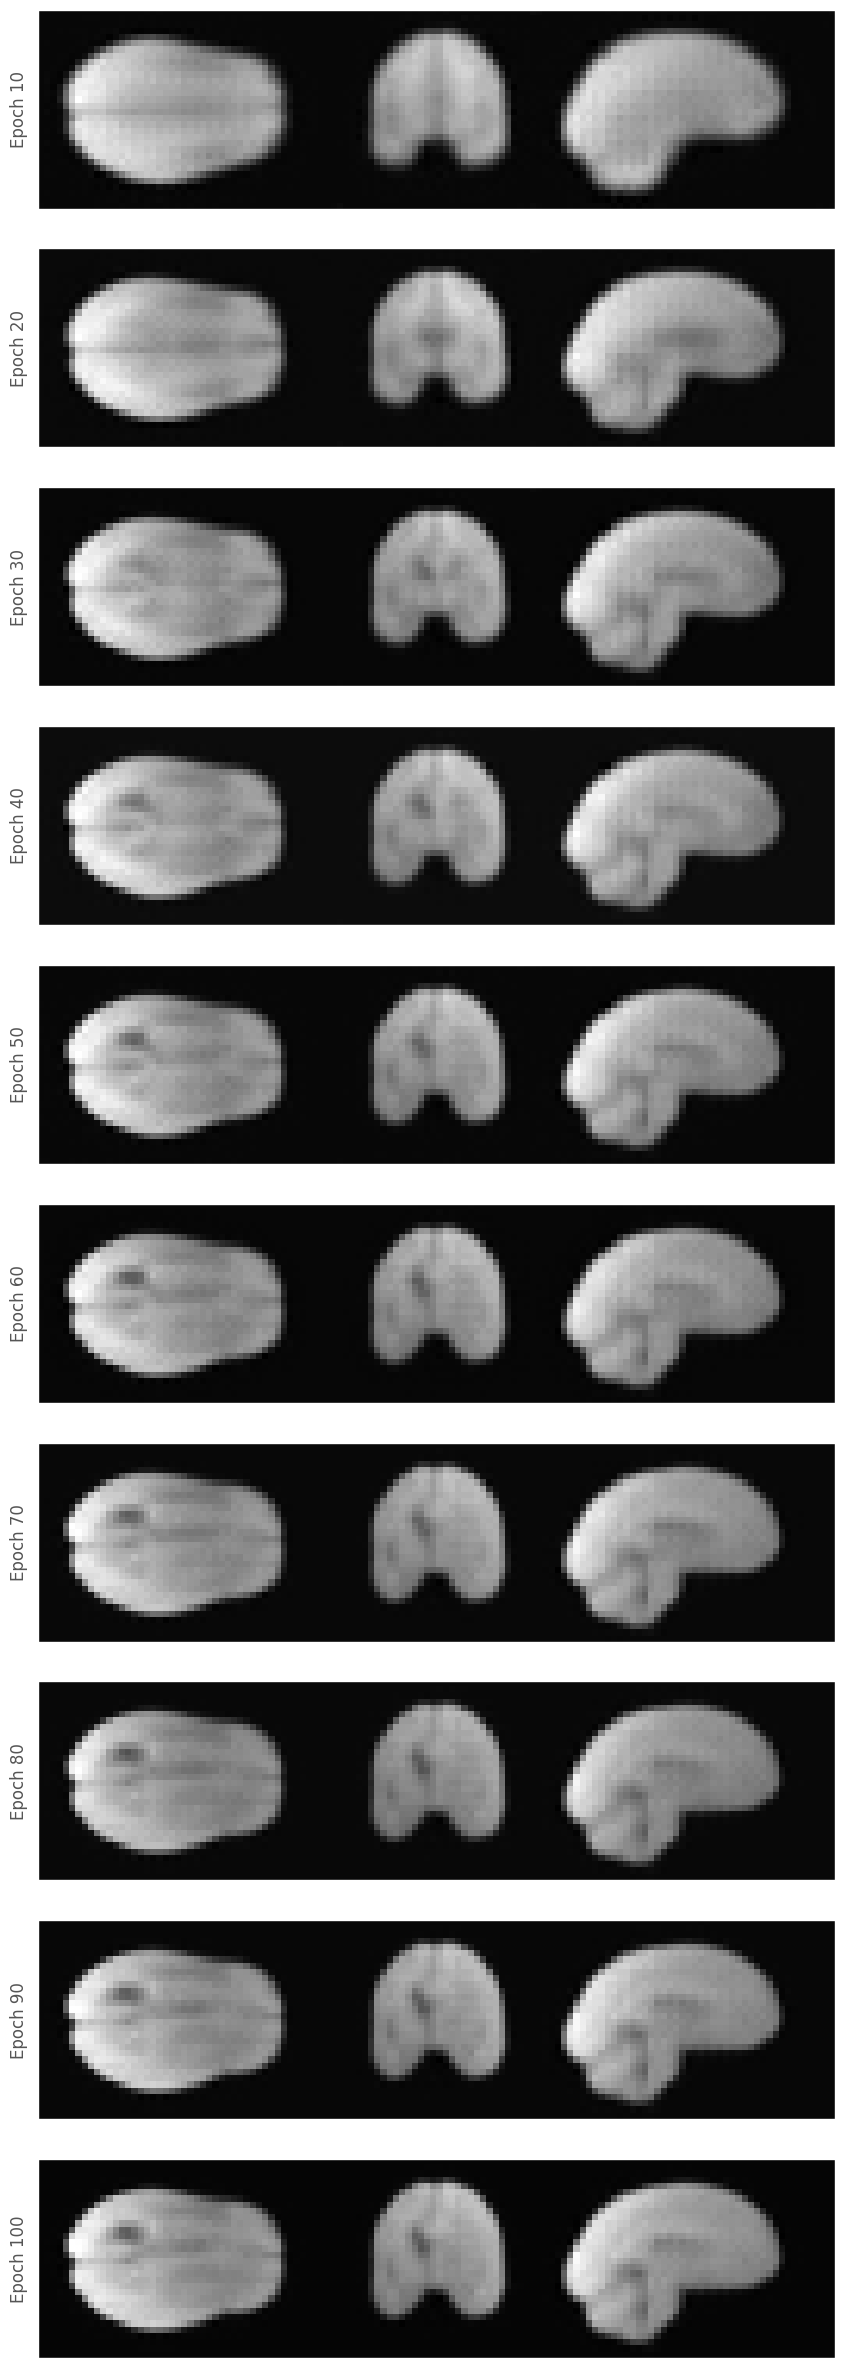

In [19]:
# Plot every evaluation as a new line and example as columns
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
fig.set_size_inches(18.5, 30.5)
for image_n in range(len(val_samples)):
    reconstructions = intermediary_images[image_n]
    reconstructions = np.concatenate(
        [
            reconstructions[0, :, :, 15],
            np.flipud(reconstructions[0, :, 24, :].T),
            np.flipud(reconstructions[0, 15, :, :].T),
        ],
        axis=1,
    )

    ax[image_n].imshow(reconstructions, cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

### Plotting the reconstructions from final trained model

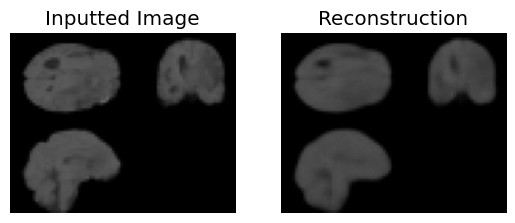

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2)
plt.style.use("default")
plotting_image_0 = np.concatenate([images[0, 0, :, :, 15].cpu(), np.flipud(images[0, 0, :, 24, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(images[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
image = np.concatenate([plotting_image_0, plotting_image_1], axis=0)

ax[0].imshow(image, vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")

plotting_image_2 = np.concatenate(
    [reconstruction[0, 0, :, :, 15].cpu(), np.flipud(reconstruction[0, 0, :, 24, :].cpu().T)], axis=1
)
plotting_image_3 = np.concatenate([np.flipud(reconstruction[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
reconstruction_3d = np.concatenate([plotting_image_2, plotting_image_3], axis=0)
ax[1].imshow(reconstruction_3d, vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)